This notebook describes the steps performed to create the Benthos product.

In [1]:
using DIVAnd
using PyPlot
using NCDatasets
using Missings
using Interpolations
using Plots

if VERSION >= v"0.7"
    using Random
    using DelimitedFiles
    using Statistics
    using Printf
    using FileIO
else
    using Compat: @info, @warn, range, cat
end

# Module where the output grid and the modules are defined
include("../src/emodnet_bio_grid.jl");
include("../src/make_benthos_products.jl");

## Prepare the grid and the mask

In [2]:
# Grid stored in emodnet_bio_grid.jl
xi,yi = DIVAnd.ndgrid(gridlonBenthos, gridlatBenthos);

# Mask
topodir = "../data/"
topofile = joinpath(topodir, "gebco_30sec_8.nc");

if isfile(topofile)
    bx, by, b = DIVAnd.load_bath(topofile,true,gridlonBenthos, gridlatBenthos);
    xmask, ymask, mmask = DIVAnd.load_mask(topofile,true,gridlonBenthos, gridlatBenthos,[0]);
else
    @error "Bathymetry file doesn't exist"
end
mmask = mmask[:,:,1]
@info size(mmask)

# Metrics
pm = ones(size(xi)) / (xi[2,1]-xi[1,1]);
pn = ones(size(xi)) / (yi[1,2]-yi[1,1]);

┌ Info: (451, 371)
└ @ Main In[2]:15


### Read data

In [6]:
fname = joinpath(datadir, "Olivier-Benthos/Benthos_Total_densities_ab.csv");
@info "Reading data file $(fname)"
obslon, obslat, g1, g2, g3 = read_benthos_abs(fname);
@info extrema(obslat)
@info extrema(obslon)

┌ Info: Reading data file /home/ctroupin/tmp/Emodnet-Bio/Olivier-Benthos/Benthos_Total_densities_ab.csv
└ @ Main In[6]:2
┌ Info: (1.0555555556, 210.0555555556)
└ @ Main In[6]:4
┌ Info: (-9.39937, 203.1666666667)
└ @ Main In[6]:5


## Parameter choice 
Chose via sensitivity analysis, as the optimisation tools provide too low values for L and noise-to-signal ratio.

In [7]:
# Correlation length
len = 5.;
# Observational error variance normalized by the background error variance
epsilon2 = 10.;

The weight is decreased for very close points.

In [9]:
rdiag=1.0./DIVAnd.weight_RtimesOne((obslon, obslat),(0.03,0.03))
@show maximum(rdiag),mean(rdiag);
epsilon2 = epsilon2*rdiag;

(maximum(rdiag), mean(rdiag)) = (439.4143004395609, 33.622283414778)


## Perform analysis

In [10]:
@info "Interpolating"
fi1rel, fi2rel, fi3rel, totalfield = make_analysis(obslon, obslat, g1, g2, g3);

┌ Info: Interpolating
└ @ Main In[10]:1


  1.581240 seconds (2.60 M allocations: 1.465 GiB, 40.78% gc time)
  1.326266 seconds (2.30 M allocations: 1.450 GiB, 39.21% gc time)
  1.426488 seconds (2.30 M allocations: 1.450 GiB, 36.18% gc time)


### Make plot

In [11]:
make_plot_grid_new(fi1rel, fi2rel, fi3rel, totalfield; vmin=0., vmax=1.)
PyPlot.savefig(joinpath("../figures/Benthos_Total_densities_ab.png"), dpi=300, bbox_inches="tight")

UndefVarError: UndefVarError: make_plot_grid_new not defined

## Error field
We use the so-called *Clever Poor Man's Estimate*.

In [12]:
g1_err, g2_err, g3_err = compute_error(obslon, obslat, g1, g2, g3);

### Make plot

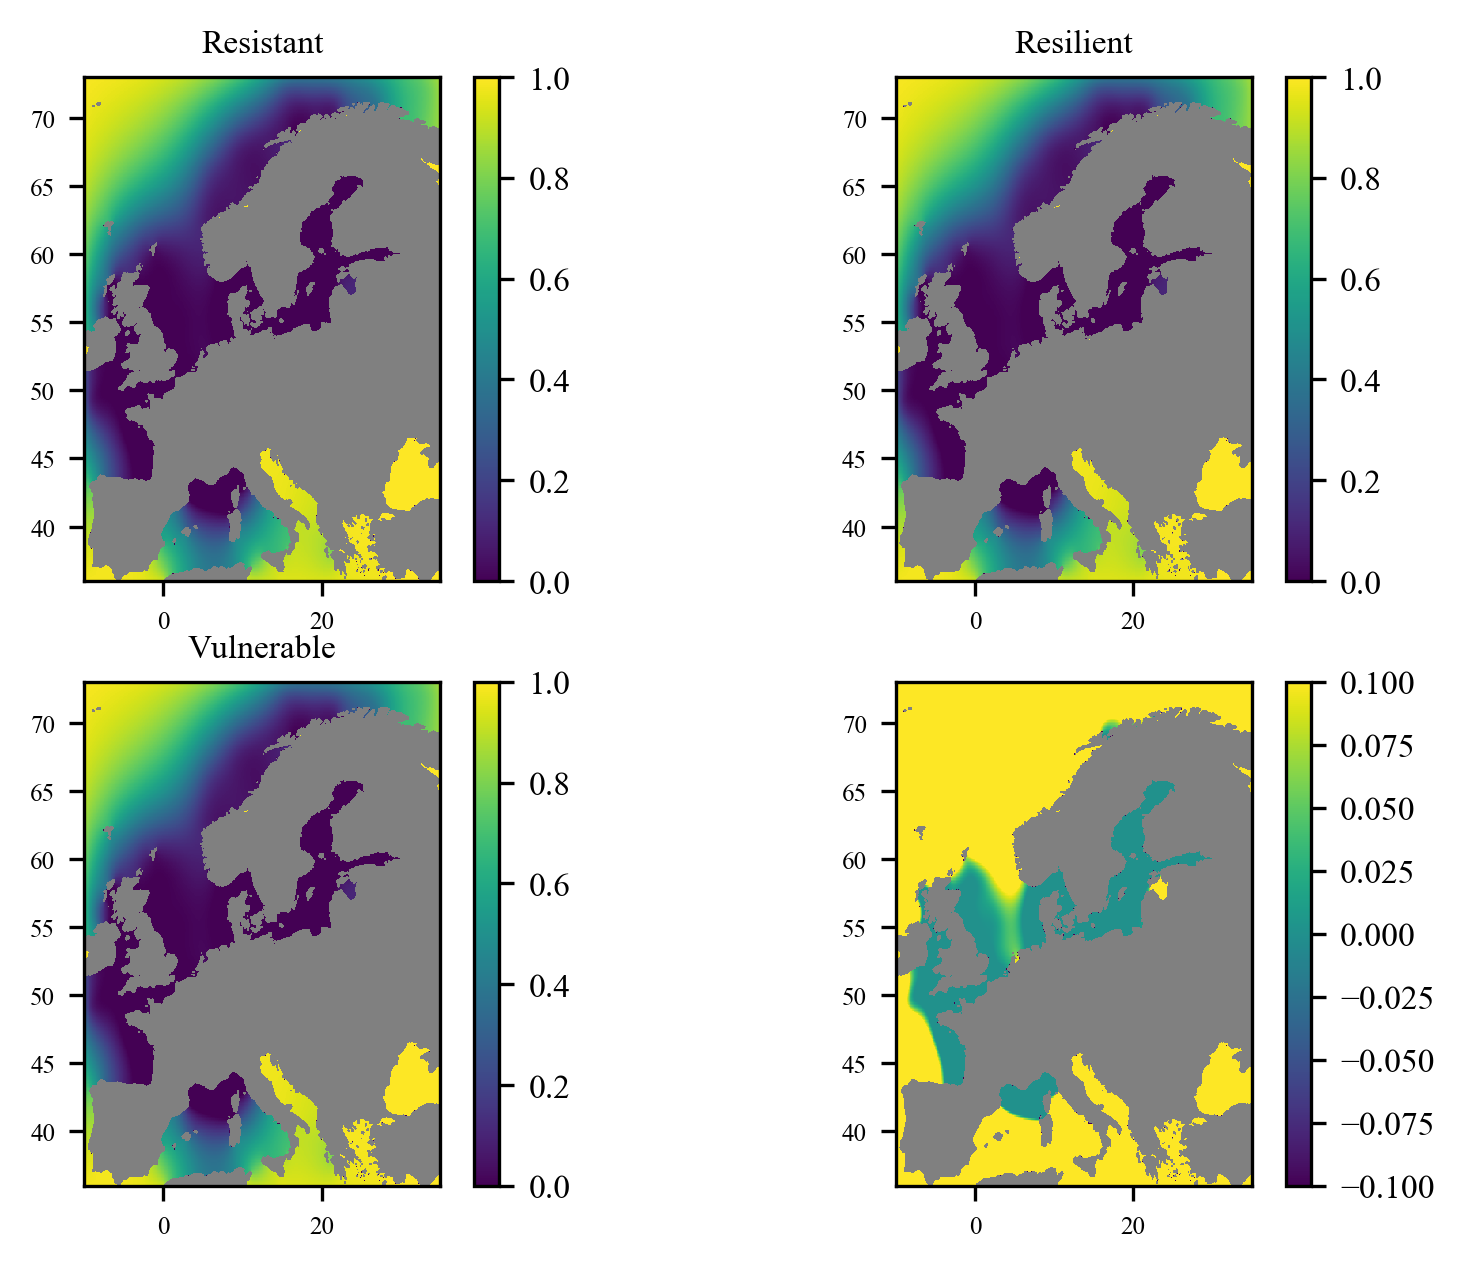

In [14]:
make_plot_grid(g1_err, g2_err, g3_err, g1_err + g2_err + g3_err, vmin=0, vmax=1.)

## Write the results and the error field in a netCDF file
Create new output directory if necessary.

In [13]:
outputdir = "../output/"
if !isdir(outputdir)
    @info("Creating output directory $(outputdir)")
    mkdir(outputdir);
end
@info "Write netCDF"
write_benthos_nc(joinpath(outputdir, "Benthos_Total_densities_ab.nc"), gridlonBenthos, gridlatBenthos,
fi1rel, fi2rel, fi3rel, g1_err, g2_err, g3_err);

┌ Info: Write netCDF
└ @ Main In[13]:6


## Analysis of the density file
The same procedure is repeated with the density data.

In [ ]:
fname = joinpath(datadir, "Olivier-Benthos/Benthos_tabDens.csv");
@info "Reading data file $(fname)"
obslon2, obslat2, g1b, g2b, g3b = read_benthos(fname);
@info extrema(obslat2)
@info extrema(obslon2)
@info "Interpolating"
f1brel, f2brel, f3brel, totalfieldb = make_analysis(obslon2, obslat2, g1b, g2b, g3b);
@info "Computing error field"
g1b_err, g2b_err, g3b_err = compute_error(obslon2, obslat2, g1b, g2b, g3b);

### Make plot

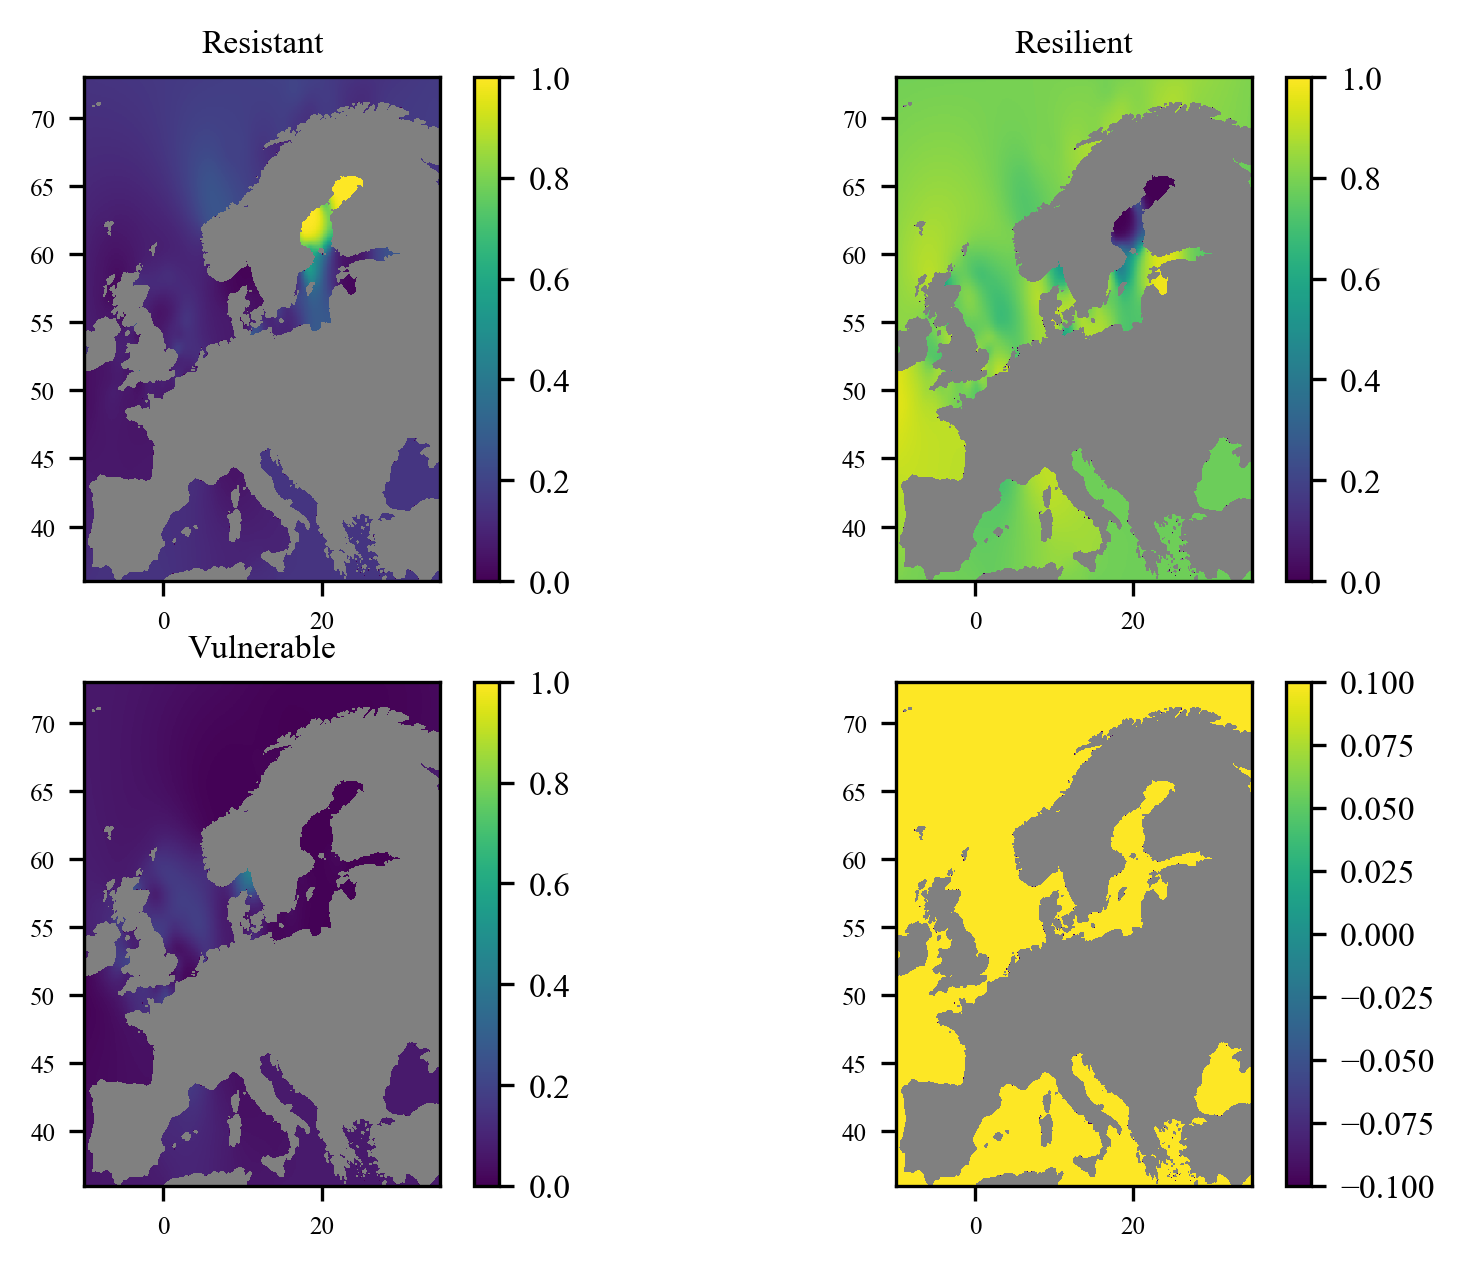

In [106]:
make_plot_grid(f1brel, f2brel, f3brel, totalfieldb; vmin=0., vmax=1.)
PyPlot.savefig(joinpath("../figures/Benthos_tabDens.png"), dpi=300, bbox_inches="tight")

### Write netCDF

In [51]:
@info "Write netCDF"
write_benthos_nc(joinpath(outputdir, "Benthos_tabDens.nc"), gridlonBenthos, gridlatBenthos,
f1brel, f2brel, f3brel, g1b_err, g2b_err, g3b_err);

┌ Info: Write netCDF
└ @ Main In[51]:1


In [85]:
cb

PyObject <matplotlib.colorbar.Colorbar object at 0x7fb385dcab00>